# Bayesian Networks

In this notebook, I explain what a Bayesian network is and how it works, and I do a medical informatics case study to demonstrate the material I cover.

*Data for this notebook is from the CDC's [COVID-19 Case Surveillance Public Use Data with Geography](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data-with-Ge/n8mc-b4w4/data) dataset, filtered to remove rows with missing or unknown values.*

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from network import CategoricalBayesianNetwork
from pathlib import Path

if Path.cwd().name == 'notebooks':
    %cd ..


## What is a Bayesian network?

A **Bayesian network** is a statistical method for representing causal relationships between variables. Here is a simple example:

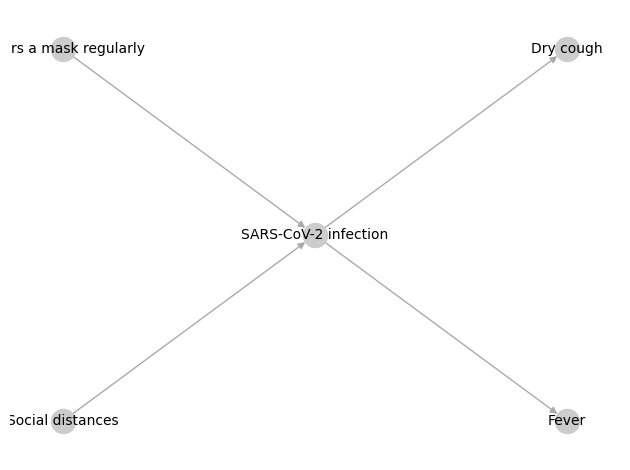

In [17]:
network = CategoricalBayesianNetwork()
network.add_variables('Wears a mask regularly', 'Social distances', 'SARS-CoV-2 infection', 'Fever', 'Dry cough')
network.add_dependencies_to('SARS-CoV-2 infection', ['Wears a mask regularly', 'Social distances'])
network.add_dependency_to('Fever', 'SARS-CoV-2 infection')
network.add_dependency_to('Dry cough', 'SARS-CoV-2 infection')
fig, ax = plt.subplots()
network.draw(ax=ax, font_size=10, node_color='#cccccc', edge_color='#aaaaaa')
fig.tight_layout()

In this network, there are five variables: whether the person wears a mask, whether they social distance, and whether they've been infected with SARS-CoV-2, whether they have a fever, and whether they have a dry cough.

The arrows in the network represent what we perceive as causal relationships between variables. For example, we'd expect that wearing a mask has an impact on SARS-CoV-2 infection probability, so there is an arrow from "Wears a mask regularly" to "SARS-CoV-2 infection." A SARS-CoV-2 infection may cause the symptoms on the right, so there is an arrow to those.

A Bayesian network's structure is represented by something called a **directed acyclic graph** (DAG). "Graph" means that this is a structure with relationships between nodes represented by edges, "directed" means those directions go in one way, and "acyclic" means that, if one were to travel from node to node using only the directed edges, it is impossible to return to where you started. Practically, this last restriction means that you can't have variables that depend on each other.

Already, it's clear that Bayesian networks are relatively simple compared to other machine learning models. They're not black boxes, which is important as other algorithms rise to prominence without us actually being able to understand how the machine works on the inside. I'll elaborate on this point in the next section.

 ## The math of Bayesian networks

From a mathematical view, Bayesian networks are a way of representing a joint probability distribution using the "chain rule" of probability ($\mathrm{Pr}\left(X,Y\right) = \mathrm{Pr}\left(X \mid Y\right)\mathrm{Pr}\left(Y\right)$). For example, in a simple Bayesian network where $B$ depends on $A$, the joint probability distribution is:
$
\mathrm{Pr}\left(A,B\right) = \mathrm{Pr}\left(B \mid A\right)\mathrm{Pr}\left(A\right)
$
Notice that there is one term for each node in the network, and that the distribution corresponding to $B$ depends on all the variables connected into $B$. Because $A$ depends on no other variables, its probability distribution is not conditioned on any other variables.

For the SARS-CoV-2 Bayesian network above, the representation of the joint probability distribution of all the variables is:
$
\mathrm{Pr}\left(F,C,I,D,M\right) =
\mathrm{Pr}\left(F \mid I\right)\mathrm{Pr}\left(C \mid I\right)\mathrm{Pr}\left(I \mid D,M\right)\mathrm{Pr}\left(D\right)\mathrm{Pr}\left(M\right)
$
As before, each term represents each node and its parent nodes.

As long as you have a good grasp on probability, it's relatively simple to interpret a Bayesian network. This simplicity also holds a lot of power. I haven't yet specified exactly what type of probability distribution we're talking about for each node, and that's because you can use *any* probability distribution to represent a variable in a Bayesian network. You can even mix and match probability distributions. However, Bayesian networks are often almost exclusively used with discrete and Gaussian distributions for computational simplicity.

This mathematical lens also reveals a limitation of Bayesian networks: Despite representing causal links, Bayesian networks are *not* causal. Why? The joint probability distribution does not care about variable order:
$
\mathrm{Pr}\left(X,Y\right) =
\mathrm{Pr}\left(X \mid Y\right)\mathrm{Pr}\left(Y\right) =
\mathrm{Pr}\left(Y \mid X\right)\mathrm{Pr}\left(X\right)
$
This equality shows that reversing any edge in the network has no effect. It *is* actually possible to determine causal relationships between variables, and I will discuss this later.

## Introducing the example

Let's now start with the main example of this notebook, which is a network modeling outcomes of SARS-CoV-2 infections.

In [18]:
# Get data
save_path = Path('data/covid_data.csv')

if save_path.exists():
    df = pd.read_csv(save_path)
else:
    raise FileNotFoundError('Data is missing.')

# Drop columns that I'm ignoring
df.drop(columns=['case_month', 'state_fips_code', 'res_county', 'county_fips_code', 'case_positive_specimen_interval', 'process', 'current_status', 'case_onset_interval', 'exposure_yn', 'symptom_status'], inplace=True)
# It's best to convert all of these to categorical data.
df = df.apply(lambda col: col.astype('category'), axis=0)
df

,res_state,age_group,sex,race,ethnicity,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,OH,18 to 49 years,Female,White,Hispanic/Latino,No,No,No,No
1,OH,18 to 49 years,Female,White,Hispanic/Latino,No,No,No,No
2,OH,18 to 49 years,Female,White,Hispanic/Latino,No,No,No,No
3,OH,18 to 49 years,Female,White,Non-Hispanic/Latino,No,No,No,No
4,OH,18 to 49 years,Female,White,Non-Hispanic/Latino,No,No,No,No
...,...,...,...,...,...,...,...,...,...
586469,MO,18 to 49 years,Female,White,Non-Hispanic/Latino,No,No,No,Yes
586470,TX,65+ years,Female,White,Non-Hispanic/Latino,No,No,No,Yes
586471,TX,18 to 49 years,Male,White,Hispanic/Latino,No,No,No,Yes
586472,TX,18 to 49 years,Male,White,Non-Hispanic/Latino,No,No,No,Yes


This data was filtered to exclude rows with missing values (the system I'm using does not support missing values during training, but some more advanced ones do) in the columns relevant to this investigation. I should note that this has introduced some bias into the data; most notably, most data entries are from Ohio.

These are the possible values for each column:

In [19]:
{name: df[name].cat.categories.to_list() for name in df.columns}

{'res_state': ['AK',
  'AL',
  'AR',
  'CA',
  'CO',
  'DC',
  'FL',
  'GA',
  'GU',
  'IA',
  'ID',
  'IL',
  'IN',
  'KS',
  'KY',
  'LA',
  'MD',
  'ME',
  'MI',
  'MN',
  'MO',
  'MS',
  'MT',
  'NC',
  'NE',
  'NH',
  'NJ',
  'NV',
  'NY',
  'OH',
  'OR',
  'PA',
  'PR',
  'TN',
  'TX',
  'UT',
  'VA',
  'VI',
  'VT',
  'WA',
  'WI',
  'WY'],
 'age_group': ['0 - 17 years',
  '18 to 49 years',
  '50 to 64 years',
  '65+ years'],
 'sex': ['Female', 'Male'],
 'race': ['American Indian/Alaska Native',
  'Asian',
  'Black',
  'Multiple/Other',
  'Native Hawaiian/Other Pacific Islander',
  'White'],
 'ethnicity': ['Hispanic/Latino', 'Non-Hispanic/Latino'],
 'hosp_yn': ['No', 'Yes'],
 'icu_yn': ['No', 'Yes'],
 'death_yn': ['No', 'Yes'],
 'underlying_conditions_yn': ['No', 'Yes']}

And here is the structure of the network:

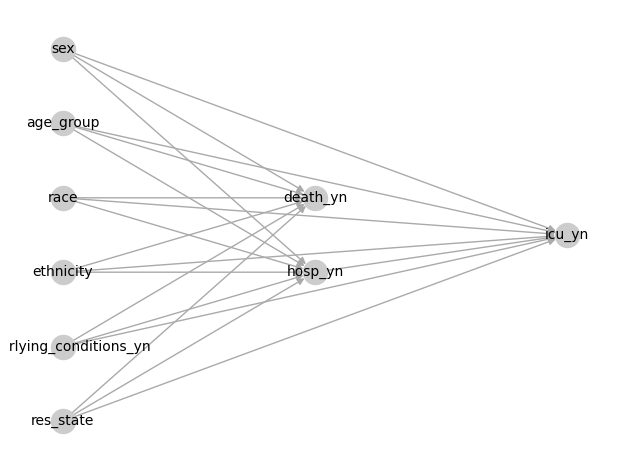

In [20]:
# I'm using a fancy wrapper around pomegranate's implementation of Bayesian networks to make the input and output data human-readable.
network = CategoricalBayesianNetwork()
network.add_variables_from_data(df)
network.add_dependencies_to('hosp_yn', ['res_state', 'age_group', 'sex', 'race', 'ethnicity', 'underlying_conditions_yn'])
network.add_dependencies_to('icu_yn', ['res_state', 'age_group', 'sex', 'race', 'ethnicity', 'underlying_conditions_yn', 'hosp_yn'])
network.add_dependencies_to('death_yn', ['res_state', 'age_group', 'sex', 'race', 'ethnicity', 'underlying_conditions_yn'])
fig, ax = plt.subplots()
network.draw(ax=ax, font_size=10, node_color='#cccccc', edge_color='#aaaaaa')
fig.tight_layout()

I chose this structure to examine the effect of the parameters in the left column on hospitalization rates, ICU admittance rates, and death rates.

## Inference with Bayesian networks

There are three main types of inference when using Bayesian networks: structure learning, parameter learning, and inferring unobserved variables.

### Structure learning

**Structure learning** is an unsupervised learning method that does exactly what you think it does. Given a set of variables and training, structure learning attempts to find a Bayesian network that describes the data. There are many methods for doing this, such as by optimizing a cost function or by cutting planes in integer programming.

However, structure learning isn't always used to give a Bayesian network its structure. In fact, one of the strengths of Bayesian networks is that they incorporate expert information, such as the network's structure. I created the structure for this example using a rudimentary understanding of cause and effect.

### Parameter learning

**Parameter learning** attempts to find conditional probability distributions for each variable in the network based on some input data. By far the simplest method for this is **maximum likelihood estimation**, which I will demonstrate with a non-Bayesian-network example.

Say you're trying to determine the probability of a coin landing heads $\theta$ given a number of independent and identically distributed tosses of the coin. In this scenario, the **likelihood function** takes as an argument the probability of the coin landing heads $\theta$ and returns the probability that the observations we've made about the coin could happen with that probability of heads. Say we observe the sequence `HHTHTTTTHT`. The probability of heads $P\left(H\right) = \theta$ and the probability of tails $P\left(T\right) = 1 - \theta$. Therefore the likelihood function $P\left(\mathcal{D} \mid \theta \right) = \theta^4\left(1 - \theta\right)^6$ because we observed 4 heads and 6 tails. The objective of maximum likelihood estimation is to find the value of the parameter $\theta$ that maximizes this function. Using some calculus, we find that the maximum likelihood estimate for $\theta$ is $0.4$.

Now let's do this with a Bayesian network. The only difference is that there are multiple parameters (one for each entry in each probability distribution for each variable). The likelihood function is the product of each of these parameters raised to a specific power. For non-conditional distributions, this power is the number of times the particular category appears in the variable's column. For a conditional probability, this power is the number of times the particular combination of categories for the probability table entry appears in the data. If this sounds complicated, after all the calculus is done, this reduces to the following expression:

For a (conditional) probability distribution of the variable $x$ in the network, the value of the parameter $\theta_{x_i | \mathrm{pa}_{X_i}}$, or the probability of a variable being a specific value in the set of categories for that variable conditioned on a particular combination of values for each of its parents, is equal to $\frac{N\left[x_i, \mathrm{pa}_{X_i}\right]}{N\left[\mathrm{pa}_{X_i}\right]$, or the number of times the particular combination of the value of $x$ and the values of its parents appears in the dataset over the number of times the particular combination of the values of its parents appears in the dataset. This is extremely fast and easy to calculate.

As an example using the main example network, let's say we wanted to find the maximum likelihood estimate of someone with a SARS-CoV-2 infection being hospitalized given that they are Asian. First, we count the number of instances where the patient is Asian and hospitalized:

In [21]:
top = len(df[(df['race'] == 'Asian') & (df['hosp_yn'] == 'Yes')])

And then we count the number of instances where the patient is Asian:

In [22]:
bottom = len(df[df['race'] == 'Asian'])

Then the maximum likelihood estimate is

In [23]:
top / bottom

0.21871725005239992

I should mention that I've made a few simplications with this example, but it's very similar to what the `fit` function would actually do for this network.

Maximum likelihood estimation is powerful due to its simplicity, but it is ineffective when handling missing values or unobserved variables. For that, there is another method called **expectation-maximization**. I won't go into detail here, but it is an iterative algorithm.

Let's fit the network to our data:

In [24]:
network.fit(df)

### Inferring unobserved variables

Say you're a hospital trying to predict the chance of hospitalization, ICU admittance, and death for some patients recently diagnosed with COVID-19 to determine what resources the hospital will need to allocate in the coming weeks. You have the following data (ignore the fact they're mostly from different states): 

In [25]:
patients = df.sample(n=10, random_state=1)
patients[['hosp_yn', 'icu_yn', 'death_yn']] = np.nan
patients

,res_state,age_group,sex,race,ethnicity,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
267163,PA,18 to 49 years,Male,White,Non-Hispanic/Latino,NaN,NaN,NaN,Yes
517972,OH,18 to 49 years,Male,Black,Non-Hispanic/Latino,NaN,NaN,NaN,Yes
30882,OH,18 to 49 years,Female,Multiple/Other,Non-Hispanic/Latino,NaN,NaN,NaN,No
305416,KS,18 to 49 years,Female,White,Non-Hispanic/Latino,NaN,NaN,NaN,Yes
149961,OH,18 to 49 years,Female,White,Non-Hispanic/Latino,NaN,NaN,NaN,Yes
447531,PA,50 to 64 years,Male,White,Non-Hispanic/Latino,NaN,NaN,NaN,Yes
367787,KY,65+ years,Female,White,Non-Hispanic/Latino,NaN,NaN,NaN,Yes
341373,TN,18 to 49 years,Female,White,Non-Hispanic/Latino,NaN,NaN,NaN,Yes
271885,VA,50 to 64 years,Female,Black,Non-Hispanic/Latino,NaN,NaN,NaN,Yes
180454,OH,65+ years,Female,White,Non-Hispanic/Latino,NaN,NaN,NaN,Yes


We can use the Bayesian network to predict these data points. The first step is to actually find the probabilities of these variables, and there are multiple methods for doing this (variable elimination, clique tree propagation, Markov chain Monte Carlo simulation, etc.).

In [26]:
probs = network.predict_proba(patients)
print('Hospitalization:')
print(probs['hosp_yn'])
print('ICU admittance:')
print(probs['icu_yn'])
print('Death:')
print(probs['death_yn'])

Hospitalization:
              No       Yes
267163  0.958298  0.041702
517972  0.885383  0.114617
30882   0.991228  0.008772
305416  0.934359  0.065641
149961  0.952922  0.047078
447531  0.894204  0.105796
367787  0.011108  0.988892
341373  0.942593  0.057407
271885  0.871903  0.128097
180454  0.735145  0.264855
ICU admittance:
              No       Yes
267163  0.991064  0.008936
517972  0.978107  0.021893
30882   0.991228  0.008772
305416  0.992615  0.007385
149961  0.994075  0.005925
447531  0.981150  0.018850
367787  0.801196  0.198804
341373  0.993839  0.006161
271885  0.975227  0.024773
180454  0.955218  0.044782
Death:
              No       Yes
267163  1.000000  0.000000
517972  1.000000  0.000000
30882   1.000000  0.000000
305416  1.000000  0.000000
149961  1.000000  0.000000
447531  0.997644  0.002356
367787  0.819425  0.180575
341373  1.000000  0.000000
271885  1.000000  0.000000
180454  0.935714  0.064286


/opt/anaconda3/envs/music/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


It's worth noting that these results demonstrate some of the issues with this dataset. The death probability of 0 indicates there wasn't an individual in the dataset with that specific combination of values. Other parameter learning methods and larger datasets can compensate for this.

Then using those probabilities, we can predict the outcomes:

In [27]:
network.predict(patients)

/opt/anaconda3/envs/music/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


,res_state,age_group,sex,race,ethnicity,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,PA,18 to 49 years,Male,White,Non-Hispanic/Latino,No,No,No,Yes
1,OH,18 to 49 years,Male,Black,Non-Hispanic/Latino,No,No,No,Yes
2,OH,18 to 49 years,Female,Multiple/Other,Non-Hispanic/Latino,No,No,No,No
3,KS,18 to 49 years,Female,White,Non-Hispanic/Latino,No,No,No,Yes
4,OH,18 to 49 years,Female,White,Non-Hispanic/Latino,No,No,No,Yes
5,PA,50 to 64 years,Male,White,Non-Hispanic/Latino,No,No,No,Yes
6,KY,65+ years,Female,White,Non-Hispanic/Latino,Yes,No,No,Yes
7,TN,18 to 49 years,Female,White,Non-Hispanic/Latino,No,No,No,Yes
8,VA,50 to 64 years,Female,Black,Non-Hispanic/Latino,No,No,No,Yes
9,OH,65+ years,Female,White,Non-Hispanic/Latino,No,No,No,Yes


In this particular set of patients, only one is likely to be hospitalized.

This is not the only type of inference: Making general probability queries is another type, and it deserves its own section.

## Probabilistic queries

Now, we want to see if there are associations between certain variables. We can do this by finding conditional probability distributions using some of the methods mentioned above.

In [28]:
analyzer = network.analyze()

/opt/anaconda3/envs/music/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


For example, we could examine the relationship between race and hospitalization in COVID-19 patients:

In [29]:
print('General:')
print(analyzer.get_probability_for('hosp_yn'))
for race in network.get_categories_for('race'):
    print(f'{race}:')
    with analyzer.freezing(race=race):
        print(analyzer.get_probability_for('hosp_yn'))

General:
No     0.758626
Yes    0.241374
Name: hosp_yn, dtype: float32
American Indian/Alaska Native:
No     0.574356
Yes    0.425644
Name: hosp_yn, dtype: float32
Asian:
No     0.730105
Yes    0.269895
Name: hosp_yn, dtype: float32
Black:
No     0.695715
Yes    0.304285
Name: hosp_yn, dtype: float32
Multiple/Other:
No     0.733102
Yes    0.266898
Name: hosp_yn, dtype: float32
Native Hawaiian/Other Pacific Islander:
No     0.534282
Yes    0.465718
Name: hosp_yn, dtype: float32
White:
No     0.769418
Yes    0.230582
Name: hosp_yn, dtype: float32


It appears that some races are hospitalized significantly more often than others within this dataset.

We could also analyze the impact of underlying conditions on chance of death:

In [30]:
print('General:')
print(analyzer.get_probability_for('underlying_conditions_yn'))
for has_underlying_conditions in network.get_categories_for('underlying_conditions_yn'):
    print(f'{has_underlying_conditions}:')
    with analyzer.freezing(underlying_conditions_yn=has_underlying_conditions):
        print(analyzer.get_probability_for('death_yn'))

General:
No     0.062997
Yes    0.937003
Name: underlying_conditions_yn, dtype: float32
No:
No     0.719293
Yes    0.280707
Name: death_yn, dtype: float32
Yes:
No     0.954789
Yes    0.045211
Name: death_yn, dtype: float32


Curiously, the chance of death given no underlying conditions is greater than the chance of death given underlying conditions. Perhaps this is due to there being greater numbers of people with underlying conditions in this dataset.

## Causation and interventional queries

I've been careful when wording the previous section to not imply causal relationships because, as mentioned before, Bayesian networks are not causal. But there are ways to determine causation in a Bayesian network through *intervention*.

Unfortunately, due to the limitations of the system I'm using for Bayesian networks and the nature of the dataset, I cannot demonstrate this with the COVID data. However, I do have another good example (from [this video](https://www.youtube.com/watch?v=NA5ZkJO3BDI)).

Let's say you're trying to figure out the causal relationship between fire and smoke. Using just standard conditional probabilities doesn't allow us to make this determination because the probability of fire increases with the observation of smoke and the probability of smoke increases with the observation of fire (or, expressed mathematically: $P\left(\text{fire}\mid\text{smoke}\right) \gt P\left(\text{fire}\mid\neg\text{smoke}\right)$ and $P\left(\text{smoke}\mid\text{fire}\right) \gt P\left(\text{smoke}\mid\neg\text{fire}\right)$). The way to actually determine causality is through experiment.

First let's perform an intervention with smoke. Over multiple trials, use a smoke generator to generate smoke and determine the proportion of trials where fire occurs. Then, take the smoke generator away and determine the proportion of trials where fire occurs, ensuring that there is no smoke. Then let's perform an intervention with fire. Over multiple trials, start a fire and determine the proportion of trials where smoke occurs. Then, make sure to prevent fire and determine the proportion of trials where smoke occurs. It's obvious that, in trials where we intervened with the smoke, the probability of fire shouldn't change, and in trials where we intervened with fire, the probability of smoke should increase with fire. Therefore, we've shown that fire causes smoke.

Mathematically, we represent intervention with the **do-operator**. $\mathrm{do}\left(X := x\right)$ indicates that an experimenter intervened with $X$ to set it to $x$. Therefore, the nature of the experiment can be expressed by:
$P\left(\text{fire}\mid\mathrm{do}\left(\text{smoke}\right)\right) = P\left(\text{fire}\mid\mathrm{do}\left(\neg\text{smoke}\right)\right)$ but
$P\left(\text{smoke}\mid\mathrm{do}\left(\text{fire}\right)\right) \gt P\left(\text{smoke}\mid\mathrm{do}\left(\neg\text{fire}\right)\right)$, so fire causes smoke.

When implementing the do-operator in Bayesian networks, you make the controlled variable dependent by **mutilation**, or making the variable depend on no other variables by removing the incoming edges to the variable's node (and marginalizing the probability distribution appropriately to account for the change). Some authors call a Bayesian network where you can do this a **causal Bayesian network** because it encodes causal information; the reason is due to some subtleties about equivalence classes that I won't get into.

## Conclusion

Bayesian networks are an effective tool for learning and understanding relationships between variables while being able to incorporate expert opinion through its simplicity.

There was a lot I wasn't able to cover in detail in this project: actually performing interventional queries, some more advanced theory of Bayesian networks, the details of handling missing values, and structure learning. 

## Sources I used

* [Bayesian network (wikipedia.com)](https://en.wikipedia.org/wiki/Bayesian_network)
* [What is a Bayesian network? (Norman Fenton, youtube.com)](https://www.youtube.com/watch?v=97KBdmSQEJ0)
* [Introduction to Bayesian Belief Networks (Jason Brownlee, machinelearningmastery.com)](https://machinelearningmastery.com/introduction-to-bayesian-belief-networks/)
* [@easylearning246 (youtube.com)](https://www.youtube.com/@easylearning246) (a channel with a complete course on Bayesian networks; only some sections of some chapters were used)
* [Bayesian Networks (Jacob Schreiber, pomegranate.readthedocs.io)](https://pomegranate.readthedocs.io/en/latest/tutorials/B_Model_Tutorial_6_Bayesian_Networks.html)